### Before start, please replace every folder path

In [1]:
import pandas as pd
import numpy as np
import copy
from math import *
import os
import random
from collections import defaultdict
import csv
from functools import reduce
from copy import deepcopy
import pickle
from timeit import default_timer as timer
from matplotlib import pyplot as plt
from ase import Atoms
from ase.io import read
from ase.io import write
from ase.visualize import view
import itertools
import time

%matplotlib inline

pd.set_option('display.max_columns', 500)

In [2]:
%run classes.py
%run utilities.py

In [3]:
folder_path = 'CHA_36'

In [5]:
#need to change path before running the following command
!mkdir CHA_36/lattice_clusters
!mkdir CHA_36/lattice_clusters/xyzs
!mkdir CHA_36/lattice_clusters/images

mkdir: CHA_36/lattice_clusters: File exists
mkdir: CHA_36/lattice_clusters/xyzs: File exists
mkdir: CHA_36/lattice_clusters/images: File exists


In [6]:
#need to change path before running the following command
!mkdir CHA_36/structure_clusters_rep
!mkdir CHA_36/structure_clusters_rep/xyzs
!mkdir CHA_36/structure_clusters_rep/images

mkdir: CHA_36/structure_clusters_rep: File exists
mkdir: CHA_36/structure_clusters_rep/xyzs: File exists
mkdir: CHA_36/structure_clusters_rep/images: File exists


In [7]:
#need to change path before running the following command
!mkdir CHA_36/structure_clusters_no_rep
!mkdir CHA_36/structure_clusters_no_rep/xyzs
!mkdir CHA_36/structure_clusters_no_rep/images

mkdir: CHA_36/structure_clusters_no_rep: File exists
mkdir: CHA_36/structure_clusters_no_rep/xyzs: File exists
mkdir: CHA_36/structure_clusters_no_rep/images: File exists


In [8]:
#need to change path before running the following command
!mkdir CHA_36/random_config_process
!mkdir CHA_36/random_config_process/xyzs
!mkdir CHA_36/random_config_process/images

mkdir: CHA_36/random_config_process: File exists
mkdir: CHA_36/random_config_process/xyzs: File exists
mkdir: CHA_36/random_config_process/images: File exists


#### Read lat.in

In [9]:
lattice = Lattice(folder_path)

#### Run corrdump, generate clusters.out

In [10]:
#need to change path before running the following command
!corrdump -l=CHA_36/lat.in -cf=CHA_36/clusters.out -2=6.2 -3=6.2

Unable to open structure file


#### Read clusters.out

In [11]:
lattice.read_clusters_out()

In [8]:
#visualize sites without any cluster
#lattice.visualize_cluster()

In [9]:
#visualize all clusters
#for cluster_type in lattice.cluster_types:
#    lattice.visualize_cluster(cluster_type=cluster_type)

In [10]:
#cluster_type = '3-6'
#c= read(folder_path+'/lattice_clusters/xyzs/cluster-{}.xyz'.format(cluster_type))
#view(c)

#### read str_dim.txt

In [12]:
structure = Structure(lattice=lattice, folder_path=folder_path)

In [13]:
structure.prepare_str_out()

In [14]:
#need to change path before running the following command
if os.path.isfile('CHA_36/cluster_list.csv'):
    os.remove('CHA_36/cluster_list.csv')
    
!corrdump -l=CHA_36/lat.in -s=CHA_36/str.out -cf=CHA_36/clusters.out -2=6.2 -3=6.2 >> CHA_36/cluster_list.csv

In [15]:
structure.read_cluster_list()

In [ ]:
#structure.visualize_one_cluster_type_all_examples('3-3')

In [ ]:
#visualize_structure_all_clusters(str_clusters, structure, folder_path, rep='y')

In [21]:
len(structure.sites[structure.sites.multi_atoms==1].index)

972

In [16]:
pickle.dump(lattice, open(folder_path+'/jobs/lattice.p','wb'))

In [17]:
pickle.dump(structure, open(folder_path+'/jobs/structure.p','wb'))

In [19]:
penalty = {'2-1':1, '2-2':1, '2-3':1, '2-4':1}

In [22]:
pickle.dump(penalty, open(folder_path+'/jobs/penalty.p', 'wb'))

#### jobs

In [4]:
lattice=pickle.load(open(folder_path+'/jobs/lattice.p','rb'))
structure=pickle.load(open(folder_path+'/jobs/structure.p','rb'))
penalty=pickle.load(open(folder_path+'/jobs/penalty.p', 'rb'))

In [5]:
Al_num = 12
num_vecs = 10
num_steps = 10
penalty_factor = 10

In [7]:
str_vecs = structure.random_config_swap(atom_num=Al_num, penalty=penalty, factor=penalty_factor, num_vecs=num_vecs, num_step=num_steps, burn_in_period=0, ptime=1)

In [14]:
str_vecs = structure.random_config_swap(atom_num=Al_num, penalty=penalty, factor=penalty_factor, num_vecs=num_vecs, num_step=num_steps, burn_in_period=burn_in_period)

results = structure.titrate_clusters_multi_configs(str_vecs, titration_groups=[['2-7','2-11']], excluding_types=['3-6'], titrate_num=1000)

ps = []
for str_vec in str_vecs:
    ps.append(structure.cal_penalty_str_config(str_vec, penalty))

#### panalty vs time for different penalty factor

In [9]:
swap_str_vec_py_template = '''import pandas as pd
import numpy as np
import copy
from math import *
import os
import random
from collections import defaultdict
import csv
from functools import reduce
from copy import deepcopy
import pickle
from timeit import default_timer as timer
from matplotlib import pyplot as plt
from ase import Atoms
from ase.io import read
from ase.io import write
from ase.visualize import view
import itertools
import time

from utilities import *
from classes import *

lattice=pickle.load(open('lattice.p','rb'))
structure=pickle.load(open('structure.p','rb'))
penalty=pickle.load(open('penalty.p', 'rb'))
Al_num = 243
num_vecs = 1000000
num_steps = 1000000
penalty_factor = {0}

str_vecs = structure.random_config_swap(atom_num=Al_num, penalty=penalty, factor=penalty_factor, num_vecs=num_vecs, num_step=num_steps, burn_in_period=0, ptime=1)

ps = []
for str_vec in str_vecs:
    ps.append(structure.cal_penalty_str_config(str_vec, penalty))
    
pickle.dump(str_vecs, open('swap_str_vecs_{0}.p','wb'))
pickle.dump(ps, open('swap_ps_{0}.p','wb'))

'''

In [10]:
swap_qscript_template = '''#!/bin/bash
#$ -q *@@crc_d12chas
#$ -pe smp 1
python J_swap_{}.py
'''

In [17]:
# filename = folder_path+'/jobs/J_test.py'.format(penalty_factor)
# with open(filename, 'w+') as file:
#     file.write(swap_str_vec_py_template.format(penalty_factor))
# filename = folder_path+'/jobs/J_test.sh'.format(penalty_factor)
# with open(filename, 'w+') as file:
#     file.write(swap_qscript_template.format(penalty_factor))

In [12]:
for penalty_factor in [1, 5, 10, 20]:
    filename = folder_path+'/jobs/J_swap_{}.py'.format(penalty_factor)
    with open(filename, 'w+') as file:
        file.write(swap_str_vec_py_template.format(penalty_factor))
    filename = folder_path+'/jobs/J_swap_{}.sh'.format(penalty_factor)
    with open(filename, 'w+') as file:
        file.write(swap_qscript_template.format(penalty_factor))

#### generate str_vecs using select algorithm

In [13]:
select_str_vec_py_template = '''import pandas as pd
import numpy as np
import copy
from math import *
import os
import random
from collections import defaultdict
import csv
from functools import reduce
from copy import deepcopy
import pickle
from timeit import default_timer as timer
from matplotlib import pyplot as plt
from ase import Atoms
from ase.io import read
from ase.io import write
from ase.visualize import view
import itertools
import timeit

from utilities import *
from classes import *

lattice=pickle.load(open('lattice.p','rb'))
structure=pickle.load(open('structure.p','rb'))
penalty=pickle.load(open('penalty.p', 'rb'))
Al_num = 243
num_vecs = 1000

select_str_vecs = structure.random_config_select(atom_num=Al_num, penalty=penalty, num_vecs=num_vecs)

pickle.dump(select_str_vecs, open('select_str_vecs.p','wb'))

'''

In [14]:
select_qscript_template = '''#!/bin/bash
#$ -q *@@crc_d12chas
#$ -pe smp 1
python J_select.py
'''

#### swap with 5000 iterations

In [41]:
swap_5000_py_template = '''import pandas as pd
import numpy as np
import copy
from math import *
import os
import random
from collections import defaultdict
import csv
from functools import reduce
from copy import deepcopy
import pickle
from timeit import default_timer as timer
from matplotlib import pyplot as plt
from ase import Atoms
from ase.io import read
from ase.io import write
from ase.visualize import view
import itertools
import time

from utilities import *
from classes import *

lattice=pickle.load(open('lattice.p','rb'))
structure=pickle.load(open('structure.p','rb'))
penalty=pickle.load(open('penalty.p', 'rb'))

Al_num = 243
num_vecs = 1
num_steps = 5010
penalty_factor = 20

str_vec = structure.random_config_swap(atom_num=Al_num, penalty=penalty, factor=penalty_factor, num_vecs=num_vecs, num_step=num_steps, burn_in_period=5000)[0]

result = structure.titrate_config_one_group(str_vec, titration_types=['2-7', '2-11'], excluding_types=['3-6'])[0]

t = result['2-7'] + result['2-11']
    
with open('swap_titration_result_243.txt', 'a') as f:
    f.write(str(t)+\'\\n\')

'''

In [42]:
swap_5000_qscript_template = '''#!/bin/bash
#$ -q *@@crc_d12chas
#$ -pe smp 1
python J_{}.py
'''

In [44]:
for i in range(1,1001):
    filename = folder_path+'/swap/J_{}.py'.format(i)
    with open(filename, 'w+') as file:
        file.write(swap_5000_py_template)
    filename = folder_path+'/swap/J_{}.sh'.format(i)
    with open(filename, 'w+') as file:
        file.write(swap_5000_qscript_template.format(i))

#### select 

In [55]:
select_py_template = '''import pandas as pd
import numpy as np
import copy
from math import *
import os
import random
from collections import defaultdict
import csv
from functools import reduce
from copy import deepcopy
import pickle
from timeit import default_timer as timer
from matplotlib import pyplot as plt
from ase import Atoms
from ase.io import read
from ase.io import write
from ase.visualize import view
import itertools
import time

from utilities import *
from classes import *

lattice=pickle.load(open('lattice.p','rb'))
structure=pickle.load(open('structure.p','rb'))
penalty=pickle.load(open('penalty.p', 'rb'))

str_vecs = pickle.load(open('select_str_vecs.p','rb'))
str_vec = str_vecs[{0}]

result = structure.titrate_config_one_group(str_vec, titration_types=['2-7', '2-11'], excluding_types=['3-6'])[0]

t = result['2-7'] + result['2-11']
    
with open('select_titration_result_243.txt', 'a') as f:
    f.write(str(t)+\'\\n\')

'''

In [56]:
select_qscript_template = '''#!/bin/bash
#$ -q *@@crc_d12chas
#$ -pe smp 1
python J_sel_{}.py
'''

In [57]:
for i in range(1,2):
    filename = folder_path+'/select/J_sel_{}.py'.format(i)
    with open(filename, 'w+') as file:
        file.write(select_py_template.format(i-1))
    filename = folder_path+'/select/J_sel_{}.sh'.format(i)
    with open(filename, 'w+') as file:
        file.write(select_qscript_template.format(i))

#### run jobs

In [58]:
def run_job(filename):
    from subprocess import Popen, PIPE
    qscript = filename
    p = Popen(['qsub', qscript], stdin=PIPE, stdout=PIPE, stderr=PIPE)
    p.communicate()
    return


In [ ]:
for i in range(1,1001):
    filename = folder_path+'/swap/J_{}.sh'.format(i)
    run_job(filename)

In [ ]:
for i in range(1,2):
    filename = folder_path+'/select/J_sel_{}.sh'.format(i)
    with open(filename, 'w+') as file:
        file.write(select_qscript_template.format(i))

#### results

In [4]:
def read_txt_file_to_float(filepath):
    file = open(filepath, 'r')
    lines = file.readlines()
    return [float(x) for x in lines]

In [5]:
penalty_factors = [1, 5, 10, 20]

In [6]:
ps = {}
ts = {}
for pf in penalty_factors:
    ps[pf] = read_txt_file_to_float(folder_path+'/ps_{}.txt'.format(pf))
    ts[pf] = read_txt_file_to_float(folder_path+'/time_{}.txt'.format(pf))

In [60]:
taverage = [(ts[1][i]+ts[5][i]+ts[10][i]+ts[20][i])/4 for i in range(10000)]

In [7]:
number_of_swaps = np.arange(1, 1+len(ps[1]))

In [8]:
select_results = read_txt_file_to_float(folder_path+'/select_titration_result_243.txt')
swap_results = read_txt_file_to_float(folder_path+'/swap_titration_result_243.txt')

In [73]:
plt.rcParams.update({'font.size': 25})
plt.rcParams["figure.figsize"] = (16,9)
plt.rcParams["xtick.labelsize"] = 25
plt.rcParams["ytick.labelsize"] = 25
plt.rcParams["axes.labelsize"] = 30
plt.rcParams['legend.fontsize'] = 22
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.titlepad'] = 25
plt.rcParams['axes.labelpad'] = 25

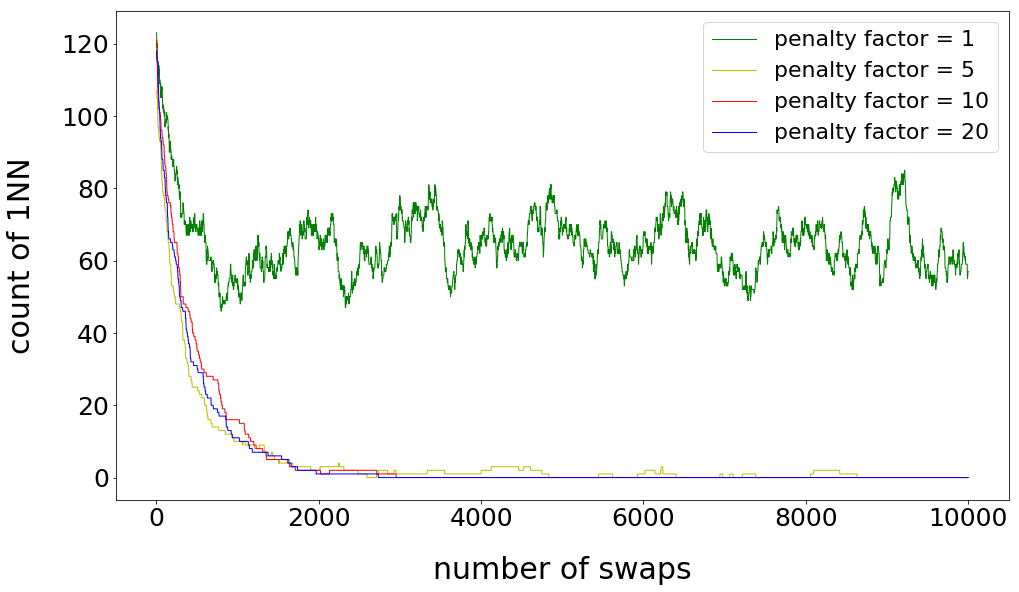

In [48]:
fig, ax = plt.subplots()
ax.plot(number_of_swaps[:10000], ps[1][:10000], label='penalty factor = 1',linewidth=1,c='g')
ax.plot(number_of_swaps[:10000], ps[5][:10000], label='penalty factor = 5',linewidth=1,c='y')
ax.plot(number_of_swaps[:10000], ps[10][:10000], label='penalty factor = 10',linewidth=1, c='r')
ax.plot(number_of_swaps[:10000], ps[20][:10000], label='penalty factor = 20',linewidth=1, c='b')
ax.set_xlabel('number of swaps')
ax.set_ylabel('count of 1NN')
plt.legend();

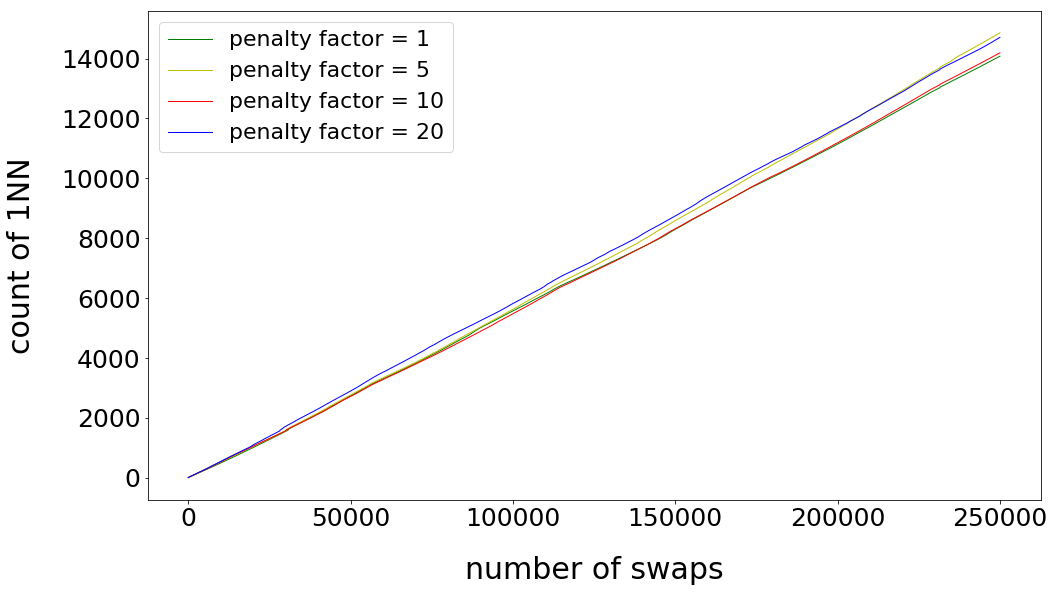

In [57]:
fig, ax = plt.subplots()
ax.plot(number_of_swaps[:250000], ts[1][:250000], label='penalty factor = 1',linewidth=1,c='g')
ax.plot(number_of_swaps[:250000], ts[5][:250000], label='penalty factor = 5',linewidth=1,c='y')
ax.plot(number_of_swaps[:250000], ts[10][:250000], label='penalty factor = 10',linewidth=1, c='r')
ax.plot(number_of_swaps[:250000], ts[20][:250000], label='penalty factor = 20',linewidth=1, c='b')
ax.set_xlabel('number of swaps')
ax.set_ylabel('count of 1NN')
plt.legend();

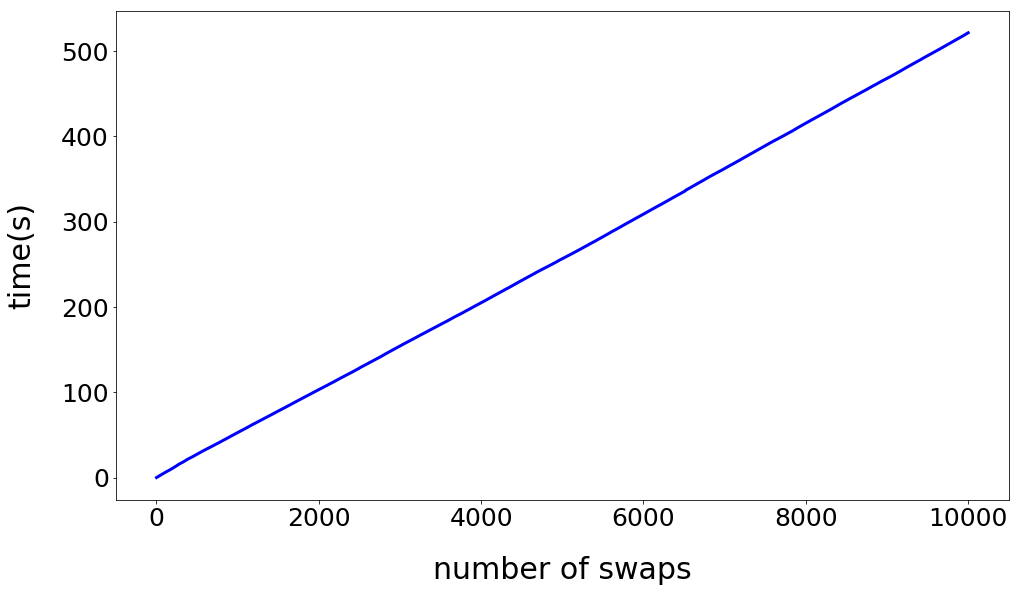

In [109]:
fig, ax = plt.subplots()
ax.plot(number_of_swaps[:10000], taverage, linewidth=3, c='b')
ax.set_xlabel('number of swaps')
ax.set_ylabel('time(s)');

In [63]:
taverage[5000]

256.74475461244583

In [9]:
np.mean(select_results)/243

0.3074638424432663

In [10]:
np.mean(swap_results)/243

0.29169086782255504

In [11]:
np.std(select_results)/243

0.020964270922823682

In [12]:
np.std(swap_results)/243

0.021593906328639303

In [13]:
Chris_data_2016 = [0.290530303030303, 0.2261363636363637, 0.13143939393939397, 0.09166666666666673, 0.0679924242424243, 0.05473484848484855, 0.046212121212121315, 0.03768939393939397, 0.03390151515151518, 0.030113636363636398]

In [14]:
Chris_data_2014 =[0.269, 0.229, 0.18, 0.141, 0.089,0.0596,0.0524,0.0482,0.0398, 0.0344]

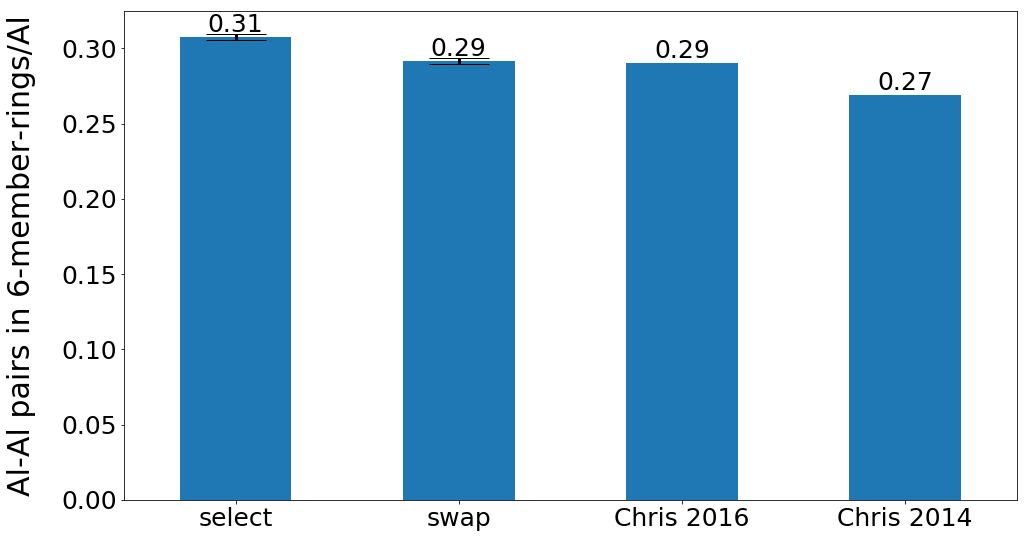

In [107]:
x_labels = ['select', 'swap', 'Chris 2016', 'Chris 2014']
values = [np.mean(select_results)/243, np.mean(swap_results)/243, 0.29053, 0.269]
value_series = pd.Series.from_array(values)
x_labels = x_labels
ind = np.arange(4)  # the x locations for the groups
width = 0.35       # the width of the bars
yerr = [np.std(select_results)/243/1000**(1/3),np.std(swap_results)/243/1000**(1/3),np.nan,np.nan]
# now to plot the figure...

plt.figure()
ax = value_series.plot(kind='bar', yerr=yerr)

plt.errorbar(ind , value_series, yerr=yerr,capsize=30, elinewidth=3, c='k', ls='none')

ax.set_ylabel('Al-Al pairs in 6-member-rings/Al')
ax.set_xticklabels(x_labels)

plt.setp(ax.xaxis.get_majorticklabels(), rotation=0 )

rects = ax.patches

# Now make some labels
labels = ['{:.2f}'.format(x) for x in values]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, label, ha='center', va='bottom')
